# AVI 파일 구조

### RIFF 헤더 구조
|위치|이름|크기|의미|
|----|---|---|---|
|0x00|groupID|4|RIFF 파일임을 나타낸다|
|0x04|groupSize|4|헤더 8 바이트를 제외한 파일 크기|
|0x08|riffType|4|AVI 파일을 나타낸다. "AVI" 가 저장되어 있음|

### 청크 구조
|위치|이름|크기|의미|
|----|---|---|---|
|0x00|chunkID|4|어떤 종류의 청크인지 나타낸다|
|0x04|chunkSize|4|ID와 size 8바이트를 제외한 실제 저장된 데이터 크기|
|0x08|Data|n|실제 저장된 데이터|

### List 구조
|위치|이름|크기|의미|
|----|---|---|---|
|0x00|groupID|4|List임을 나타내는 문자열, "LIST"가 저장되어 있다|
|0x04|listSize|4|ID와 size 8바이트를 제외한 실제 저장된 데이터 크기|
|0x08|ListType|n|실제 저장된 데이터|
|0x0c|Data|n|실제 저장된 데이터, Chunk 또는 또 다른 list가 올수 있다|

## AVI (Audio Video InterLeave)
- 마이크로소프트사에서 만든 디지텇 비디오 파일 포맷
- 오디오와 비디오를 함께 포함할 수 있으며, 여러 개의 오디오 또는 비디오 스트림을 가질 수 있다.
- 압축하지 않은 비디오와 압축된 비디오 포맷 동시 지원
- RIFF 의 특별한 한 형태


## RIFF (Resource Interchange File Format, 리소스 교환 파일 형식)
- 마이크로소프트, IBM이 공동으로 개발한 멀티미디어 데이터를 저장하고 교환하기 위한 파일 형식
- WAV 오디오 파일과 AVI 비디오 파일에서 많이 사용됨

### RIFF 구조
- 데이터를 청크(chunk)라는 단위로 나누어 저장, 각각의 청크는 FOURCC(Four-character code)라는 4개의 문자로 이루어진 코드로 구분, 청크는 4바이트의 FOURCC 코드, 해당 청크의 크기를 나타내는 4바이트, 그리고 청크 데이터로 구성



In [12]:
import struct

def parse_avi(file_path):
    with open(file_path, 'rb') as f:
        # RIFF 헤더 읽기
        riff_header = f.read(12)
        riff, file_size, avi = struct.unpack('<4sI4s', riff_header)
        
        if riff != b'RIFF' or avi != b'AVI ':
            raise ValueError("This is not a valid AVI file.")
        
        print(f"RIFF Header: {riff.decode('ascii')}, File Size: {file_size}, Format: {avi.decode('ascii')}")

        # 파일 끝까지 반복적으로 청크를 읽습니다.
        while f.tell() < file_size:
            # 청크 헤더 읽기 (청크 ID와 크기)
            chunk_header = f.read(8)
            if len(chunk_header) < 8:
                break
            chunk_id, chunk_size = struct.unpack('<4sI', chunk_header)
            
            print(f"Chunk ID: {chunk_id.decode('ascii')}, Chunk Size: {chunk_size}")
            
            # 청크의 시작 위치를 저장하고, 청크 데이터를 건너뜁니다.
            chunk_start = f.tell()

            if chunk_id == b'avih':
                # avih 섹션의 구조를 파싱합니다.
                avih_data = f.read(56)
                (dwMicroSecPerFrame, dwMaxBytesPerSec, dwPaddingGranularity, dwFlags,
                 dwTotalFrames, dwInitialFrames, dwStreams, dwSuggestedBufferSize,
                 dwWidth, dwHeight) = struct.unpack('<IIIIIIIIII', avih_data)
                
                print("Main AVI Header Information:")
                print(f"  Microseconds per frame: {dwMicroSecPerFrame}")
                print(f"  Max bytes per second: {dwMaxBytesPerSec}")
                print(f"  Total frames: {dwTotalFrames}")
                print(f"  Width: {dwWidth}, Height: {dwHeight}")
            else:
                # 청크 데이터를 건너뜁니다.
                f.seek(chunk_size, 1)

            # 청크 크기가 홀수면 패딩 바이트가 있으므로 1바이트 추가로 건너뜁니다.
            if chunk_size % 2 == 1:
                f.seek(1, 1)
                
            # 다음 청크로 이동
            f.seek(chunk_start + chunk_size)

avi_file_path = r'C:\Users\samsung\PycharmProjects\ComputerVision\king.avi'
parse_avi(avi_file_path)


RIFF Header: RIFF, File Size: 169270, Format: AVI 
Chunk ID: LIST, Chunk Size: 4588
Chunk ID: LIST, Chunk Size: 26
Chunk ID: JUNK, Chunk Size: 1016
Chunk ID: LIST, Chunk Size: 158636
Chunk ID: idx1, Chunk Size: 4960


### VFW(Video For Windows)
- 1
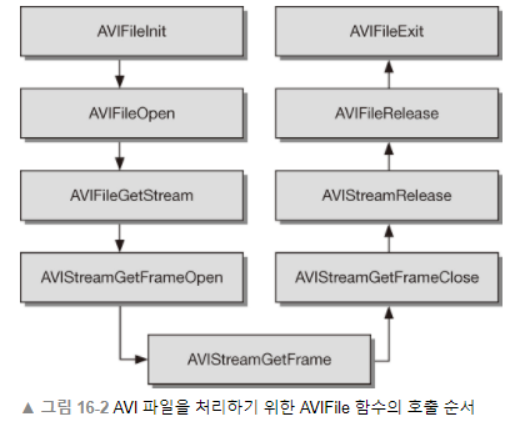
#### AVIFile 함수
- RIFF 구조를 바이트 단위로 읽어서 분석할 필요 없이 손쉽게 RIFF 파일을 처리할 수 있도록 도와줌
- 청크 단위로 AVI 파일을 분석하지 않고도 여러 개의 데이터 스트림 다루기 가능
##### 함수 기능
- AVIFileInit: VFW AVIFile 라이브러리를 초기화
- AVIFileOpen: AVI 파일을 열고, 파일 인터페이스에 대한 포인터를 받아오는 역할
- AVIFileGetStream: 열려있는 AVI 파일에서 스트림 인터페이스의 주소를 얻음
- AVIStreamGetFrameOpen: 비디오 스트림으로부터 압축되지 않은 비디오 프레임을 준비
- AVIStreamGetFrame: 특정 프레임의 영상을 DIB 구조로 얻어오기위해 사용
- AVIStreamGetFrameClose: 프레임 닫음
- AVIStreamRelease: 스트림을 닫고, 스트림과 관련된 모든 리소스 해제
- AVIFileRelease: AVI 파일을 닫고, 파일과 관련된 모든 리소스 해제
- AVIFileExit: VFW 라이브러리 종료



In [29]:
# 파이썬에서는 VFW 대신 OpenCV로 avi 처리 가능

import cv2

class IppAvi:
    def __init__(self):
        self.cap = None
        self.frame_rate = 0
        self.total_frames = 0
        self.width = 0
        self.height = 0

    def open(self, file_path):
        self.cap = cv2.VideoCapture(file_path)
        if not self.cap.isOpened():
            return False
        self.frame_rate = int(self.cap.get(cv2.CAP_PROP_FPS))
        self.total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        return True

    def close(self):
        if self.cap:
            self.cap.release()
            self.cap = None

    def draw_frame(self, n_frame, dx=0, dy=0, dw=None, dh=None):
        if self.cap is None:
            print("Video is not opened.")
            return
        
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, n_frame)
        ret, frame = self.cap.read()
        if not ret:
            print(f"Failed to retrieve frame {n_frame}")
            return

        if dw is not None and dh is not None:
            frame = cv2.resize(frame, (dw, dh))

        cv2.imshow(f"Frame {n_frame}", frame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    def get_frame(self, n_frame):
        if self.cap is None:
            print("Video is not opened.")
            return None
        
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, n_frame)
        ret, frame = self.cap.read()
        if not ret:
            print(f"Failed to retrieve frame {n_frame}")
            return None
        
        return frame

    def get_frame_rate(self):
        return self.frame_rate

    def get_total_frame(self):
        return self.total_frames

    def get_height(self):
        return self.height

    def get_width(self):
        return self.width

    def is_valid(self):
        return self.cap is not None
    
    # 특정 프레임을 파일로 저장
    def save_frame(self, n_frame, file_path):
        frame = self.get_frame(n_frame)
        if frame is not None:
            cv2.imwrite(file_path, frame)
            print(f"Saved frame {n_frame} to {file_path}")
            

avi = IppAvi()
avi_file_path = r'C:\Users\samsung\PycharmProjects\ComputerVision\king.avi'
# AVI 파일 열기
if avi.open(avi_file_path):
    print(f"Frame Rate: {avi.get_frame_rate()} fps")
    print(f"Total Frames: {avi.get_total_frame()}")
    print(f"Resolution: {avi.get_width()}x{avi.get_height()}")

    # 특정 프레임 표시
    avi.draw_frame(25)
    
    avi.save_frame(25, "frame25.jpg")
    avi.save_frame(24, "frame24.jpg")
    avi.save_frame(26, "frame26.jpg") 

    # AVI 파일 닫기
    avi.close()
else:
    print("Failed to open AVI file.")


Frame Rate: 24 fps
Total Frames: 310
Resolution: 320x240
Saved frame 25 to frame25.jpg
Saved frame 24 to frame24.jpg
Saved frame 26 to frame26.jpg


In [25]:
temp = cv2.imread("frame10.jpg")
print(temp.shape)

(240, 320, 3)




## 움직임 벡터 추정
동영상에서 영상의 시간축 방향으로의 변화를 감지하여 동영상 내 객체의 움직임을 추출하는 방법

### 블록 매칭 움직임 추정 방법

비디오 압축 분야에서 두 블록의 유사도를 평가하기 위해서 평균 절대값 차이 MAD를 주로 사용

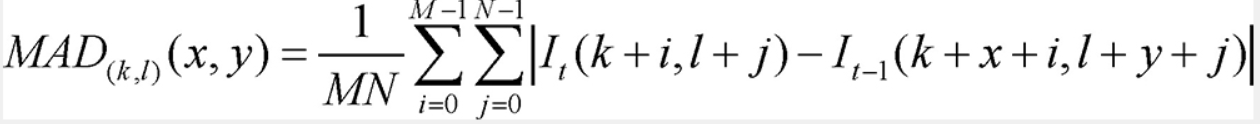

위 식에서 MAD 값을 가장 작게 만드는 변위 (x,y)의 값을 해당 블록의 움직임 벡터로 생각 가능함으로 블록 (k,l)에 해당하는 움직임 벡터를 v(k,l)로 나타내면 다음과 같음

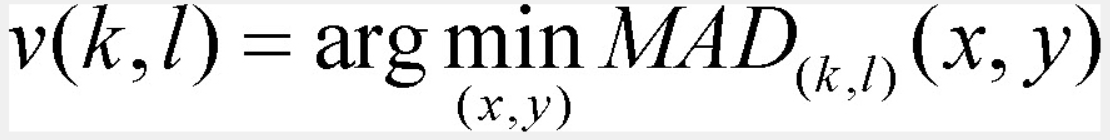


### 전체 검색 방법
아래 그림은 블록 매칭 움직임 추정 과정을 보여주는 그림
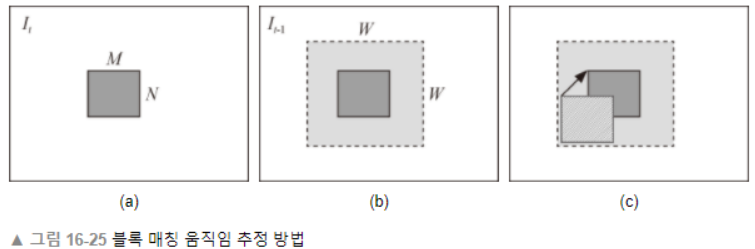

(a)는 t 번째 프레임의 MxN 크기의 블록
(b)는 (t-1) 번째 프레임에서 해당 블록 주변의 검색 윈도우의 크기를 보여줌, 이 윈도우 안에서 해당 블록과 MAD 값이 가장 작은 위치의 블록을 찾고 그 위치 변화를 움직임 벡터로 인지
(c)는 찾아낸 움직임 벡터의 모습

특정 블록 주변의 모든 변위에서 MAD 를 계산하는 방법을 전체 검색 방법이라고 한다.
가장 정확한 블록 매칭 기반 움직임 벡터를 알아낼 수 있으나 윈도우의 크기가 커질수록 연산량 많이 늘어나는 단점을 가짐

### 다이아몬드 검색
위의 전체 검색 방법의 단점을 보안하기 위해 일부 위치에 대해서만 MAD를 계산하는 방법중 하나로 빠르고 정확한 움직임 추정 방법

두 개의 검색 패턴을 가진다.

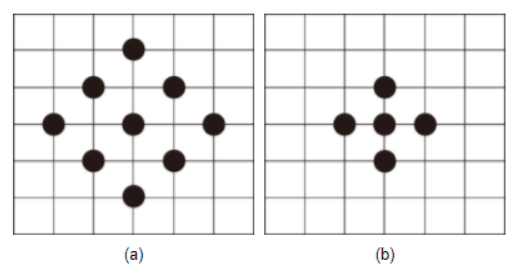

(a) = LDSP(Large Diamond Search Pattern)

(b) = SDSP(Small Diamond Search Pattern)

다이아몬드 검색 방법은 우선 LDSP 방법으로 최소 MAD 위치의 근방으로 빠르게 이동하고, 마지막에 SDSP 방법으로 정확한 위치를 찾은다.


다이아몬드 검색 알고리즘
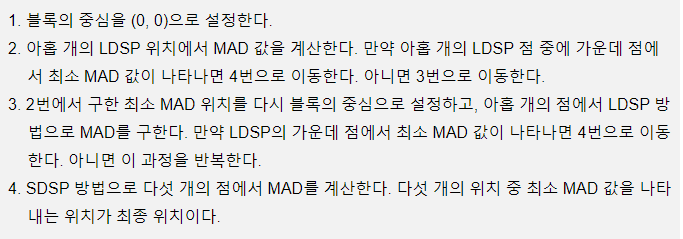


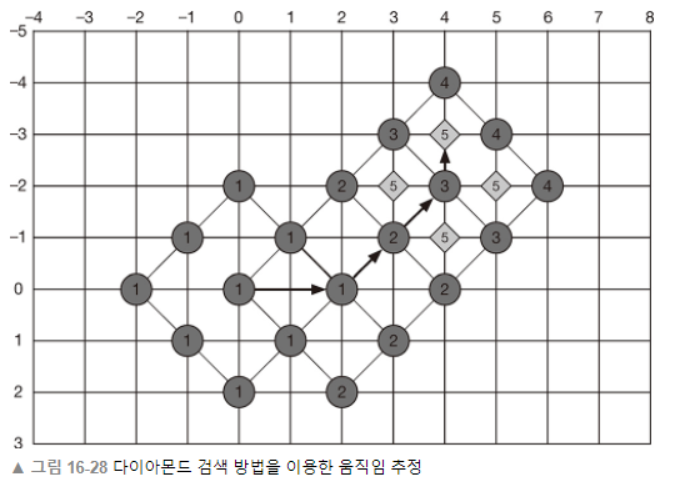


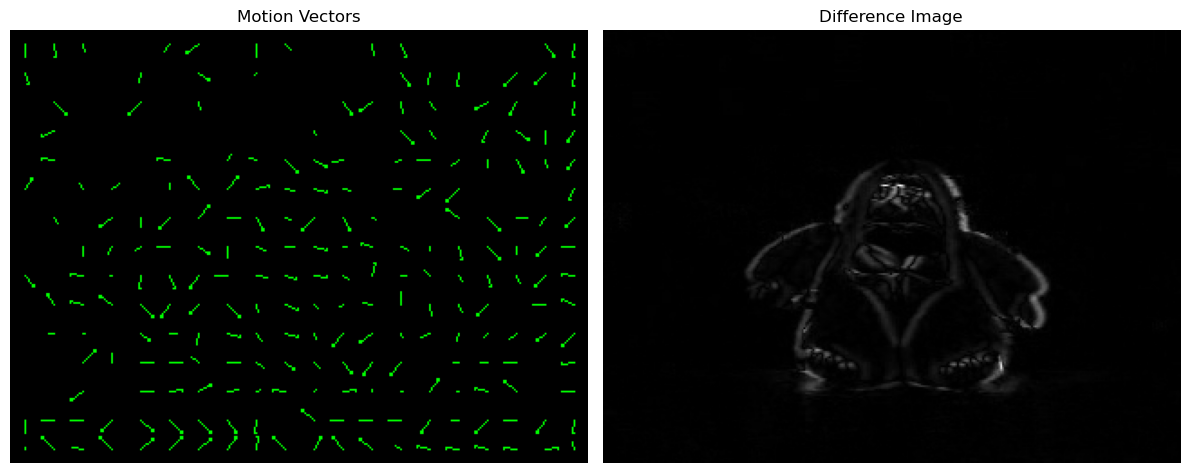

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class MotionVector:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y

class IppFullSearch:
    def __init__(self):
        self.image1 = None
        self.image2 = None
        self.motion_vectors = None
        self.block_row = 0
        self.block_col = 0
        self.block_size = 16  # 기본 블록 크기 설정

    def set_images(self, image1, image2):
        self.image1 = image1
        self.image2 = image2
        self.block_row, self.block_col = image1.shape[:2]
        self.motion_vectors = np.zeros((self.block_row, self.block_col), dtype=object)
        for i in range(self.block_row):
            for j in range(self.block_col):
                self.motion_vectors[i][j] = MotionVector()

    def get_mad(self, x1, y1, x2, y2, block_size):
        block1 = self.image1[y1:y1+block_size, x1:x1+block_size]
        block2 = self.image2[y2:y2+block_size, x2:x2+block_size]
        return np.sum(np.abs(block1 - block2)) / (block_size * block_size)

    def block_motion(self, bx, by, block_size, search_area):
        best_mad = float('inf')
        best_mv = MotionVector(0, 0)

        for dy in range(-search_area, search_area + 1):
            for dx in range(-search_area, search_area + 1):
                x2 = bx + dx
                y2 = by + dy

                if 0 <= x2 < self.image2.shape[1] - block_size and 0 <= y2 < self.image2.shape[0] - block_size:
                    mad = self.get_mad(bx, by, x2, y2, block_size)
                    if mad < best_mad:
                        best_mad = mad
                        best_mv = MotionVector(dx, dy)

        return best_mv

    def full_search(self, block_size=16, search_area=7):
        self.block_size = block_size  # 블록 크기를 멤버 변수로 저장
        for by in range(0, self.image1.shape[0] - block_size + 1, block_size):
            for bx in range(0, self.image1.shape[1] - block_size + 1, block_size):
                mv = self.block_motion(bx, by, block_size, search_area)
                self.motion_vectors[by // block_size][bx // block_size] = mv

    def get_motion_vector(self):
        return self.motion_vectors

    def get_motion_image(self):
        height, width = self.image1.shape
        motion_image = np.zeros((height, width, 3), dtype=np.uint8)

        for by in range(0, height - self.block_size + 1, self.block_size):
            for bx in range(0, width - self.block_size + 1, self.block_size):
                mv = self.motion_vectors[by // self.block_size][bx // self.block_size]
                cx = bx + self.block_size // 2
                cy = by + self.block_size // 2
                if mv.x != 0 or mv.y != 0:
                    cv2.arrowedLine(motion_image, (cx, cy), (cx + mv.x, cy + mv.y), (0, 255, 0), 1)

        return motion_image


frame1 = cv2.imread('frame24.jpg', cv2.IMREAD_GRAYSCALE)
frame2 = cv2.imread('frame25.jpg', cv2.IMREAD_GRAYSCALE)
frame3 = cv2.imread('frame26.jpg', cv2.IMREAD_GRAYSCALE)

ipp_fs = IppFullSearch()
ipp_fs.set_images(frame1, frame2)
ipp_fs.full_search()

motion_vectors = ipp_fs.get_motion_vector()
motion_image = ipp_fs.get_motion_image()

difference_image = cv2.absdiff(frame1, frame2)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(motion_image)
plt.title("Motion Vectors")
plt.axis('off')

plt.subplot(122)
plt.imshow(difference_image, cmap='gray')
plt.title("Difference Image")
plt.axis('off')

plt.tight_layout()
plt.show()


In [34]:
import cv2
import numpy as np

class MotionVector:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y

class DiamondSearch:
    def __init__(self, block_size=16, search_range=7):
        self.block_size = block_size
        self.search_range = search_range
        self.LDSP = [(0, -1), (-1, 0), (1, 0), (0, 1), (-1, -1), (1, -1), (-1, 1), (1, 1), (0, 0)]  # Large Diamond Search Pattern
        self.SDSP = [(0, -1), (-1, 0), (1, 0), (0, 1), (0, 0)]  # Small Diamond Search Pattern
        self.image1 = None
        self.image2 = None

    def set_images(self, image1, image2):
        self.image1 = image1
        self.image2 = image2

    def get_mad(self, x1, y1, x2, y2):
        block1 = self.image1[y1:y1+self.block_size, x1:x1+self.block_size]
        block2 = self.image2[y2:y2+self.block_size, x2:x2+self.block_size]
        return np.sum(np.abs(block1 - block2))

    def diamond_search(self, bx, by):
        best_mv = MotionVector()
        best_mad = self.get_mad(bx, by, bx, by)

        step_size = self.search_range // 2
        
        while step_size >= 1:
            found_better = False

            for dx, dy in self.LDSP:
                x2 = bx + dx * step_size
                y2 = by + dy * step_size

                if (0 <= x2 < self.image2.shape[1] - self.block_size and
                    0 <= y2 < self.image2.shape[0] - self.block_size):
                    mad = self.get_mad(bx, by, x2, y2)
                    if mad < best_mad:
                        best_mad = mad
                        best_mv = MotionVector(dx * step_size, dy * step_size)
                        found_better = True
            
            if found_better:
                bx += best_mv.x
                by += best_mv.y
            else:
                break
            
            step_size //= 2

        # Final refinement with small diamond pattern
        for dx, dy in self.SDSP:
            x2 = bx + dx
            y2 = by + dy

            if (0 <= x2 < self.image2.shape[1] - self.block_size and
                0 <= y2 < self.image2.shape[0] - self.block_size):
                mad = self.get_mad(bx, by, x2, y2)
                if mad < best_mad:
                    best_mad = mad
                    best_mv = MotionVector(x2 - bx, y2 - by)

        return best_mv

    def full_diamond_search(self):
        height, width = self.image1.shape
        motion_vectors = np.zeros((height // self.block_size, width // self.block_size, 2), dtype=int)

        for by in range(0, height - self.block_size + 1, self.block_size):
            for bx in range(0, width - self.block_size + 1, self.block_size):
                mv = self.diamond_search(bx, by)
                motion_vectors[by // self.block_size, bx // self.block_size] = [mv.x, mv.y]

        return motion_vectors

    def get_motion_image(self):
        height, width = self.image1.shape
        motion_image = np.stack([self.image1]*3, axis=-1)  # 원본 이미지에 컬러 채널 추가

        motion_vectors = self.full_diamond_search()

        for by in range(0, height - self.block_size + 1, self.block_size):
            for bx in range(0, width - self.block_size + 1, self.block_size):
                mv = motion_vectors[by // self.block_size][bx // self.block_size]
                cx = bx + self.block_size // 2
                cy = by + self.block_size // 2
                if mv[0] != 0 or mv[1] != 0:
                    cv2.arrowedLine(motion_image, (cx, cy), (cx + mv[0], cy + mv[1]), (0, 255, 0), 1, tipLength=0.3)

        return motion_image

# 사용 예시
frame1 = cv2.imread('frame24.jpg', cv2.IMREAD_GRAYSCALE)
frame2 = cv2.imread('frame25.jpg', cv2.IMREAD_GRAYSCALE)

ds = DiamondSearch()
ds.set_images(frame1, frame2)
motion_image = ds.get_motion_image()

# 움직임 벡터 이미지 출력
cv2.imshow('Motion Image', motion_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
